# Labo III
# Multinacional - Prediccion de Ventas

## Importamos librerias

In [1]:
# =============================================================================
# PARTE 1: LIBRERÍAS Y CONFIGURACIÓN INICIAL
# =============================================================================

# Librerías básicas para manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import pyarrow

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos de ensemble
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# Librerías para optimización y paralelización
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Configuración de reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configuración de paths (ajustar según tu estructura)
DATA_PATH = "../datasets/"
RESULTS_PATH = "../results/"

print("✅ Librerías importadas correctamente")
print(f"📊 Versión de pandas: {pd.__version__}")
print(f"🔢 Versión de numpy: {np.__version__}")
print(f"🌟 LightGBM disponible: {lgb.__version__}")
print(f"🚀 XGBoost disponible: {xgb.__version__}")
print(f"🎯 Random State configurado: {RANDOM_STATE}")

✅ Librerías importadas correctamente
📊 Versión de pandas: 2.2.3
🔢 Versión de numpy: 2.0.1
🌟 LightGBM disponible: 4.6.0
🚀 XGBoost disponible: 3.0.1
🎯 Random State configurado: 42


# funciones

In [2]:
# =============================================================================
# PARTE 2: FUNCIONES UTILITARIAS
# =============================================================================

def display_dataframe_info(df, name="DataFrame"):
    """
    Muestra información detallada sobre un DataFrame
    """
    print(f"\n{'='*50}")
    print(f"📊 INFORMACIÓN DE {name.upper()}")
    print(f"{'='*50}")
    print(f"🔹 Forma: {df.shape}")
    print(f"🔹 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"🔹 Rango de fechas: {df['periodo'].min()} a {df['periodo'].max()}" if 'periodo' in df.columns else "")
    print(f"\n📋 Tipos de datos:")
    print(df.dtypes.value_counts())
    print(f"\n🔍 Valores nulos:")
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print(null_counts[null_counts > 0])
    else:
        print("✅ No hay valores nulos")
    
    if 'tn' in df.columns:
        print(f"\n📈 Estadísticas de 'tn':")
        print(f"   • Total: {df['tn'].sum():.2f}")
        print(f"   • Promedio: {df['tn'].mean():.4f}")
        print(f"   • Mediana: {df['tn'].median():.4f}")
        print(f"   • Ceros: {(df['tn'] == 0).sum():,} ({(df['tn'] == 0).mean()*100:.1f}%)")

def validate_date_format(df, date_col='periodo'):
    """
    Valida y convierte formato de fecha
    """
    print(f"🕐 Validando formato de fecha en columna '{date_col}'...")
    
    if df[date_col].dtype == 'object':
        # Intentar convertir formato YYYYMM a datetime
        try:
            df[date_col] = pd.to_datetime(df[date_col], format='%Y%m')
            print("✅ Fecha convertida desde formato YYYYMM")
        except:
            try:
                df[date_col] = pd.to_datetime(df[date_col])
                print("✅ Fecha convertida con auto-detección")
            except:
                print("❌ Error al convertir fechas")
                return False
    
    print(f"📅 Rango de fechas: {df[date_col].min()} a {df[date_col].max()}")
    return True

def get_product_customer_lifecycles(sales_df):
    """
    Calcula los ciclos de vida de productos y clientes
    """
    print("🔍 Calculando ciclos de vida de productos y clientes...")
    
    # Ciclo de vida de productos
    product_lifecycle = sales_df.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
    product_lifecycle.columns = ['product_id', 'product_first_sale', 'product_last_sale']
    
    # Ciclo de vida de clientes
    customer_lifecycle = sales_df.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
    customer_lifecycle.columns = ['customer_id', 'customer_first_purchase', 'customer_last_purchase']
    
    # Ciclo de vida de combinaciones producto-cliente
    product_customer_lifecycle = sales_df.groupby(['product_id', 'customer_id'])['periodo'].agg(['min', 'max']).reset_index()
    product_customer_lifecycle.columns = ['product_id', 'customer_id', 'first_purchase', 'last_purchase']
    
    print(f"✅ Productos únicos: {len(product_lifecycle):,}")
    print(f"✅ Clientes únicos: {len(customer_lifecycle):,}")
    print(f"✅ Combinaciones producto-cliente: {len(product_customer_lifecycle):,}")
    
    return product_lifecycle, customer_lifecycle, product_customer_lifecycle

def calculate_metrics(y_true, y_pred, model_name="Modelo"):
    """
    Calcula métricas de evaluación
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Métrica de error porcentual personalizada
    error_percentage = np.abs(y_pred - y_true).sum() / y_true.sum() * 100
    
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Error_Percentage': error_percentage
    }
    
    print(f"\n📊 MÉTRICAS DE {model_name.upper()}")
    print("-" * 40)
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

def plot_predictions_vs_actual(y_true, y_pred, model_name="Modelo", sample_size=1000):
    """
    Grafica predicciones vs valores reales
    """
    # Tomar muestra si hay muchos datos
    if len(y_true) > sample_size:
        indices = np.random.choice(len(y_true), sample_size, replace=False)
        y_true_sample = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot
    ax1.scatter(y_true_sample, y_pred_sample, alpha=0.6, s=30)
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    ax1.set_xlabel('Valores Reales')
    ax1.set_ylabel('Valores Predichos')
    ax1.set_title(f'{model_name} - Predicho vs Real')
    ax1.grid(True, alpha=0.3)
    
    # Histograma de errores
    errors = y_pred_sample - y_true_sample
    ax2.hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.set_xlabel('Error de Predicción')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title(f'{model_name} - Distribución de Errores')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Funciones utilitarias definidas correctamente")

✅ Funciones utilitarias definidas correctamente


## Importamos datasets

In [3]:
# =============================================================================
# PARTE 3: LECTURA Y CARGA DE DATASETS
# =============================================================================

def load_datasets(data_path="../datasets/"):
    """
    Carga todos los datasets necesarios
    """
    print("📂 Iniciando carga de datasets...")
    
    try:
        # Cargar datos de ventas (sell-in)
        print("🔄 Cargando datos de ventas (sell-in.txt)...")
        sales = pd.read_csv(f"{data_path}sell-in.txt", 
                           sep="\t", 
                           dtype={"periodo": str})
        
        # Cargar datos de stock
        print("🔄 Cargando datos de stock (tb_stocks.txt)...")
        stocks = pd.read_csv(f"{data_path}tb_stocks.txt", 
                            sep="\t", 
                            dtype={"periodo": str})
        
        # Cargar información de productos
        print("🔄 Cargando información de productos (tb_productos.txt)...")
        product_info = pd.read_csv(f"{data_path}tb_productos.txt", sep="\t")
        
        # Cargar productos a predecir
        print("🔄 Cargando productos a predecir (product_id_apredecir201912.txt)...")
        products_to_predict = pd.read_csv(f'{data_path}product_id_apredecir201912.txt')
        
        print("✅ Todos los datasets cargados correctamente")
        
        return sales, stocks, product_info, products_to_predict
        
    except FileNotFoundError as e:
        print(f"❌ Error: No se pudo encontrar el archivo {e}")
        return None, None, None, None
    except Exception as e:
        print(f"❌ Error al cargar datasets: {e}")
        return None, None, None, None

def preprocess_datasets(sales, stocks, product_info, products_to_predict):
    """
    Preprocesa los datasets básicos
    """
    print("\n🔧 Iniciando preprocesamiento de datasets...")
    
    # Convertir fechas
    print("📅 Convirtiendo formatos de fecha...")
    validate_date_format(sales, 'periodo')
    validate_date_format(stocks, 'periodo')
    
    # Mostrar información inicial
    display_dataframe_info(sales, "SALES (Original)")
    display_dataframe_info(stocks, "STOCKS")
    display_dataframe_info(product_info, "PRODUCT_INFO")
    
    # Verificar productos a predecir
    print(f"\n🎯 Productos a predecir: {len(products_to_predict):,}")
    if 'product_id' in products_to_predict.columns:
        predict_products_list = products_to_predict['product_id'].unique()
    else:
        # Si la columna tiene otro nombre, intentar la primera columna
        predict_products_list = products_to_predict.iloc[:, 0].unique()
    
    print(f"📋 Lista de productos a predecir (primeros 10): {predict_products_list[:10]}")
    
    # Validar que los productos a predecir estén en los datos históricos
    products_in_sales = sales['product_id'].unique()
    missing_products = set(predict_products_list) - set(products_in_sales)
    
    if missing_products:
        print(f"⚠️  Productos a predecir que NO están en ventas históricas: {len(missing_products)}")
        print(f"    Ejemplos: {list(missing_products)[:5]}")
    else:
        print("✅ Todos los productos a predecir tienen datos históricos")
    
    # Agregar información de productos a ventas
    print("🔗 Fusionando información de productos con ventas...")
    sales_with_info = sales.merge(product_info, on='product_id', how='left')
    
    # Verificar merge
    sales_without_info = sales_with_info[sales_with_info['cat1'].isnull()]
    if len(sales_without_info) > 0:
        print(f"⚠️  Ventas sin información de producto: {len(sales_without_info):,}")
        print(f"    Productos únicos sin info: {sales_without_info['product_id'].nunique()}")
    else:
        print("✅ Todas las ventas tienen información de producto")
    
    # Agregar stocks a ventas
    print("🔗 Fusionando información de stocks con ventas...")
    sales_complete = sales_with_info.merge(stocks, on=['periodo', 'product_id'], how='left')
    
    # Mostrar resultado final
    display_dataframe_info(sales_complete, "SALES (Completo)")
    
    return sales_complete, predict_products_list

# Ejecutar carga de datos
print("🚀 INICIANDO CARGA Y PREPROCESAMIENTO DE DATOS")
print("=" * 60)

# Cargar datasets
sales, stocks, product_info, products_to_predict = load_datasets()

if sales is not None:
    # Preprocesar datasets
    sales_complete, predict_products_list = preprocess_datasets(sales, stocks, product_info, products_to_predict)
    
    print(f"\n🎉 CARGA COMPLETADA EXITOSAMENTE")
    print(f"📊 Dataset final: {sales_complete.shape[0]:,} registros")
    print(f"🎯 Productos a predecir: {len(predict_products_list):,}")
    print(f"📅 Rango temporal: {sales_complete['periodo'].min()} a {sales_complete['periodo'].max()}")
else:
    print("❌ Error en la carga de datos. Verificar paths y archivos.")

🚀 INICIANDO CARGA Y PREPROCESAMIENTO DE DATOS
📂 Iniciando carga de datasets...
🔄 Cargando datos de ventas (sell-in.txt)...


🔄 Cargando datos de stock (tb_stocks.txt)...
🔄 Cargando información de productos (tb_productos.txt)...
🔄 Cargando productos a predecir (product_id_apredecir201912.txt)...
✅ Todos los datasets cargados correctamente

🔧 Iniciando preprocesamiento de datasets...
📅 Convirtiendo formatos de fecha...
🕐 Validando formato de fecha en columna 'periodo'...
✅ Fecha convertida desde formato YYYYMM
📅 Rango de fechas: 2017-01-01 00:00:00 a 2019-12-01 00:00:00
🕐 Validando formato de fecha en columna 'periodo'...
✅ Fecha convertida desde formato YYYYMM
📅 Rango de fechas: 2018-10-01 00:00:00 a 2019-12-01 00:00:00

📊 INFORMACIÓN DE SALES (ORIGINAL)
🔹 Forma: (2945818, 7)
🔹 Memoria utilizada: 157.32 MB
🔹 Rango de fechas: 2017-01-01 00:00:00 a 2019-12-01 00:00:00

📋 Tipos de datos:
int64             4
float64           2
datetime64[ns]    1
Name: count, dtype: int64

🔍 Valores nulos:
✅ No hay valores nulos

📈 Estadísticas de 'tn':
   • Total: 1324988.59
   • Promedio: 0.4498
   • Mediana: 0.0393
   • Ceros

# Dealing with zeros

In [4]:
# =============================================================================
# PARTE 4: AGREGADO DE CEROS (LÓGICA COMPLEJA)
# =============================================================================

def create_zero_transactions(sales_df, verbose=True):
    """
    Crea transacciones con tn=0 siguiendo la lógica compleja de ciclos de vida
    
    Lógica:
    - Un producto existe desde su primera venta hasta su última venta
    - Un cliente existe desde su primera compra hasta su última compra  
    - Para cada combinación <product_id, customer_id> que esté "viva" en un período,
      si no existe transacción, se inserta una con tn=0
    """
    print("🔧 INICIANDO PROCESO DE AGREGADO DE CEROS")
    print("=" * 60)
    
    # Paso 1: Calcular ciclos de vida
    if verbose:
        print("📊 Calculando ciclos de vida...")
    
    # Ciclo de vida de productos (primera a última venta)
    product_lifecycle = sales_df.groupby('product_id')['periodo'].agg(['min', 'max']).reset_index()
    product_lifecycle.columns = ['product_id', 'product_start', 'product_end']
    
    # Ciclo de vida de clientes (primera a última compra)
    customer_lifecycle = sales_df.groupby('customer_id')['periodo'].agg(['min', 'max']).reset_index()
    customer_lifecycle.columns = ['customer_id', 'customer_start', 'customer_end']
    
    if verbose:
        print(f"   • Productos únicos: {len(product_lifecycle):,}")
        print(f"   • Clientes únicos: {len(customer_lifecycle):,}")
        print(f"   • Rango temporal: {sales_df['periodo'].min()} a {sales_df['periodo'].max()}")
    
    # Paso 2: Crear grid completo de períodos
    all_periods = pd.date_range(
        start=sales_df['periodo'].min(),
        end=sales_df['periodo'].max(),
        freq='MS'  # Month Start frequency
    )
    
    if verbose:
        print(f"   • Períodos totales: {len(all_periods)}")
    
    # Paso 3: Determinar combinaciones válidas por período
    print("🔄 Generando combinaciones válidas producto-cliente por período...")
    
    valid_combinations = []
    
    for period in tqdm(all_periods, desc="Procesando períodos"):
        # Productos vivos en este período
        active_products = product_lifecycle[
            (product_lifecycle['product_start'] <= period) & 
            (product_lifecycle['product_end'] >= period)
        ]['product_id'].values
        
        # Clientes vivos en este período  
        active_customers = customer_lifecycle[
            (customer_lifecycle['customer_start'] <= period) & 
            (customer_lifecycle['customer_end'] >= period)
        ]['customer_id'].values
        
        # Crear todas las combinaciones válidas para este período
        if len(active_products) > 0 and len(active_customers) > 0:
            period_combinations = pd.DataFrame({
                'periodo': period,
                'product_id': np.repeat(active_products, len(active_customers)),
                'customer_id': np.tile(active_customers, len(active_products))
            })
            valid_combinations.append(period_combinations)
    
    # Combinar todas las combinaciones
    print("🔗 Combinando todas las combinaciones válidas...")
    all_valid_combinations = pd.concat(valid_combinations, ignore_index=True)
    
    if verbose:
        print(f"   • Combinaciones teóricas totales: {len(all_valid_combinations):,}")
    
    # Paso 4: Identificar transacciones existentes
    print("🔍 Identificando transacciones existentes...")
    existing_transactions = sales_df[['periodo', 'product_id', 'customer_id']].copy()
    existing_transactions['exists'] = True
    
    # Paso 5: Encontrar combinaciones faltantes (que necesitan tn=0)
    print("❌ Identificando transacciones faltantes...")
    complete_grid = all_valid_combinations.merge(
        existing_transactions,
        on=['periodo', 'product_id', 'customer_id'],
        how='left'
    )
    
    missing_transactions = complete_grid[complete_grid['exists'].isnull()].copy()
    missing_transactions = missing_transactions.drop('exists', axis=1)
    
    if verbose:
        print(f"   • Transacciones existentes: {len(existing_transactions):,}")
        print(f"   • Transacciones faltantes: {len(missing_transactions):,}")
        print(f"   • Factor de multiplicación: {len(complete_grid) / len(existing_transactions):.2f}x")
    
    # Paso 6: Crear transacciones con tn=0
    print("➕ Creando transacciones con tn=0...")
    
    # Agregar columnas faltantes con valores por defecto
    missing_transactions['tn'] = 0.0
    missing_transactions['plan_precios_cuidados'] = 0
    missing_transactions['cust_request_qty'] = 0
    missing_transactions['cust_request_tn'] = 0.0
    
    # Agregar información de productos (merge con product_info)
    print("🔗 Agregando información de productos a transacciones faltantes...")
    
    # Obtener product_info del dataset original
    product_cols = ['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'descripcion']
    product_info_unique = sales_df[product_cols].drop_duplicates()
    
    missing_transactions = missing_transactions.merge(
        product_info_unique,
        on='product_id',
        how='left'
    )
    
    # Agregar stock_final como NaN (se manejará después)
    missing_transactions['stock_final'] = np.nan
    
    # Paso 7: Combinar transacciones originales con las nuevas
    print("🔄 Combinando transacciones originales con las nuevas...")
    
    # Asegurar que las columnas estén en el mismo orden
    columns_order = sales_df.columns.tolist()
    missing_transactions = missing_transactions[columns_order]
    
    # Combinar datasets
    complete_sales = pd.concat([sales_df, missing_transactions], ignore_index=True)
    
    # Ordenar por período, producto y cliente
    complete_sales = complete_sales.sort_values(['periodo', 'product_id', 'customer_id'])
    
    if verbose:
        print("\n📊 RESULTADO FINAL:")
        print(f"   • Registros originales: {len(sales_df):,}")
        print(f"   • Registros agregados (tn=0): {len(missing_transactions):,}")
        print(f"   • Total final: {len(complete_sales):,}")
        print(f"   • Factor de crecimiento: {len(complete_sales) / len(sales_df):.2f}x")
        print(f"   • Porcentaje de ceros: {(complete_sales['tn'] == 0).mean() * 100:.1f}%")
    
    return complete_sales, missing_transactions

def validate_zero_insertion(complete_sales, original_sales, verbose=True):
    """
    Valida que el proceso de inserción de ceros sea correcto
    """
    print("\n🔍 VALIDANDO INSERCIÓN DE CEROS")
    print("-" * 40)
    
    # Verificar que no se perdieron transacciones originales
    original_sum = original_sales['tn'].sum()
    new_sum = complete_sales[complete_sales['tn'] > 0]['tn'].sum()
    
    if abs(original_sum - new_sum) < 0.01:  # Pequeña tolerancia por precisión float
        print("✅ Suma de ventas originales preservada")
    else:
        print(f"❌ ERROR: Suma original: {original_sum:.2f}, Nueva suma: {new_sum:.2f}")
    
    # Verificar estructura temporal
    periods_original = set(original_sales['periodo'].unique())
    periods_new = set(complete_sales['periodo'].unique())
    
    if periods_original == periods_new:
        print("✅ Períodos temporales preservados")
    else:
        print(f"❌ ERROR: Períodos diferentes")
    
    # Estadísticas de ceros
    zero_count = (complete_sales['tn'] == 0).sum()
    total_count = len(complete_sales)
    zero_percentage = (zero_count / total_count) * 100
    
    print(f"📊 Registros con tn=0: {zero_count:,} ({zero_percentage:.1f}%)")
    print(f"📊 Registros con tn>0: {total_count - zero_count:,} ({100-zero_percentage:.1f}%)")
    
    if verbose:
        display_dataframe_info(complete_sales, "SALES (Con Ceros)")
    
    return True

# Ejecutar proceso de agregado de ceros
print("🚀 EJECUTANDO AGREGADO DE CEROS")
print("⚠️  ADVERTENCIA: Este proceso puede tomar varios minutos...")
print("📊 Dataset inicial:", sales_complete.shape)

# Ejecutar el proceso
complete_sales_with_zeros, added_zero_transactions = create_zero_transactions(
    sales_complete, 
    verbose=True
)

# Validar el resultado
validate_zero_insertion(complete_sales_with_zeros, sales_complete, verbose=True)

print("\n🎉 PROCESO DE AGREGADO DE CEROS COMPLETADO")
print(f"📈 Crecimiento: {sales_complete.shape[0]:,} → {complete_sales_with_zeros.shape[0]:,}")

🚀 EJECUTANDO AGREGADO DE CEROS
⚠️  ADVERTENCIA: Este proceso puede tomar varios minutos...
📊 Dataset inicial: (2945818, 14)
🔧 INICIANDO PROCESO DE AGREGADO DE CEROS
📊 Calculando ciclos de vida...
   • Productos únicos: 1,233
   • Clientes únicos: 597
   • Rango temporal: 2017-01-01 00:00:00 a 2019-12-01 00:00:00
   • Períodos totales: 36
🔄 Generando combinaciones válidas producto-cliente por período...


Procesando períodos:   0%|          | 0/36 [00:00<?, ?it/s]

Procesando períodos: 100%|██████████| 36/36 [00:00<00:00, 207.62it/s]

🔗 Combinando todas las combinaciones válidas...


   • Combinaciones teóricas totales: 15,563,113
🔍 Identificando transacciones existentes...
❌ Identificando transacciones faltantes...
   • Transacciones existentes: 2,945,818
   • Transacciones faltantes: 12,617,295
   • Factor de multiplicación: 5.28x
➕ Creando transacciones con tn=0...
🔗 Agregando información de productos a transacciones faltantes...
🔄 Combinando transacciones originales con las nuevas...

📊 RESULTADO FINAL:
   • Registros originales: 2,945,818
   • Registros agregados (tn=0): 12,617,295
   • Total final: 15,563,113
   • Factor de crecimiento: 5.28x
   • Porcentaje de ceros: 81.1%

🔍 VALIDANDO INSERCIÓN DE CEROS
----------------------------------------
✅ Suma de ventas originales preservada
✅ Períodos temporales preservados
📊 Registros con tn=0: 12,617,295 (81.1%)
📊 Registros con tn>0: 2,945,818 (18.9%)

📊 INFORMACIÓN DE SALES (CON CEROS)
🔹 Forma: (15563113, 14)
🔹 Memoria utilizada: 5954.55 MB
🔹 Rango de fechas: 2017-01-01 00:00:00 a 2019-12-01 00:00:00

📋 Tipos de 

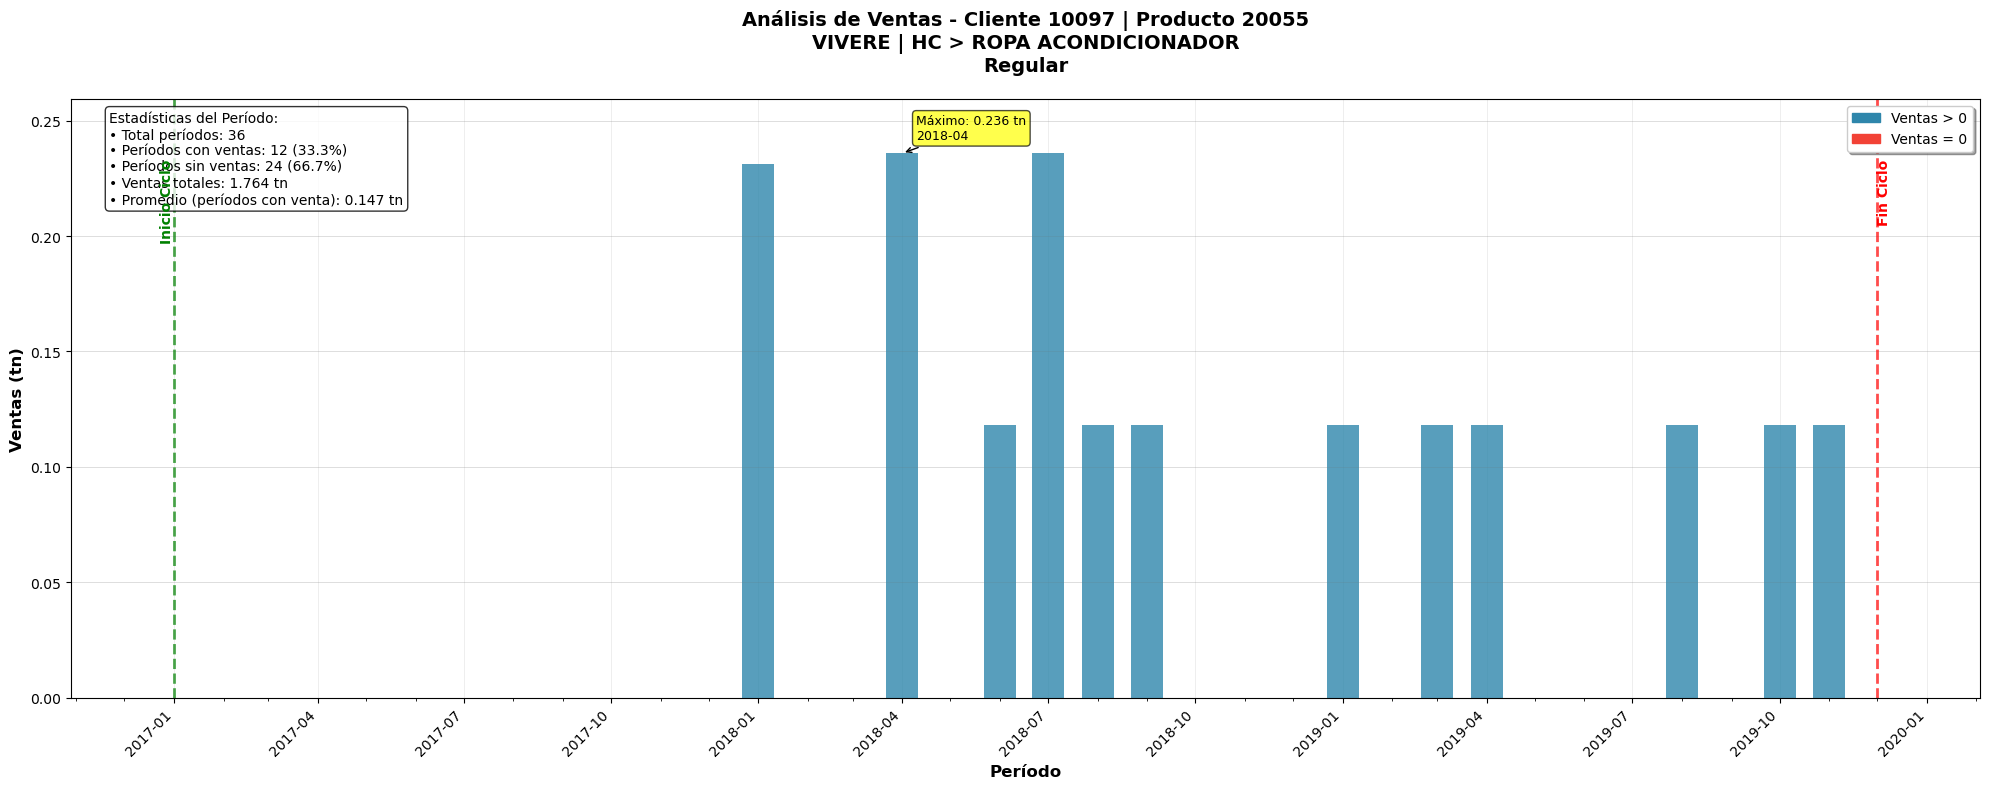

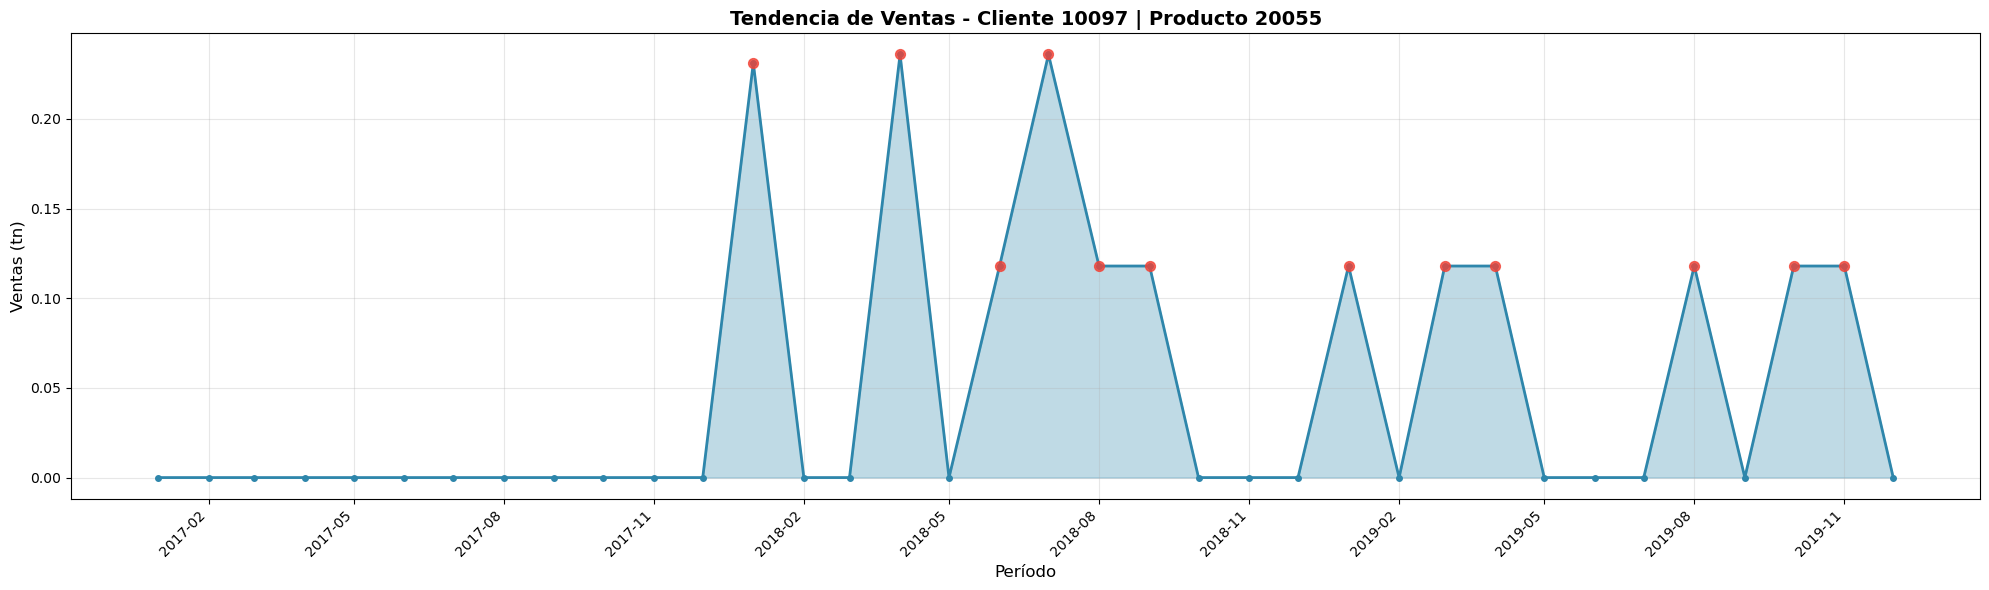

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.patches as mpatches

def create_improved_sales_chart(complete_sales_with_zeros, customer_id, product_id):
    """
    Crea un gráfico mejorado para analizar las ventas de un cliente-producto específico
    """
    # Filtrar datos
    filtered_df = complete_sales_with_zeros[
        (complete_sales_with_zeros['customer_id'] == customer_id) & 
        (complete_sales_with_zeros['product_id'] == product_id)
    ].copy()
    
    # Asegurar que 'periodo' sea datetime
    filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])
    filtered_df = filtered_df.sort_values('periodo')
    
    # Obtener información adicional del producto
    product_info = filtered_df[['cat1', 'cat2', 'brand', 'descripcion']].iloc[0]
    
    # Configurar el estilo
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Crear colores diferenciados para ventas reales vs ceros
    colors = ['#2E86AB' if tn > 0 else '#F24236' for tn in filtered_df['tn']]
    
    # Crear el gráfico de barras
    bars = ax.bar(filtered_df['periodo'], filtered_df['tn'], 
                  color=colors, alpha=0.8, width=20)  # width en días
    
    # Personalizar el gráfico
    ax.set_title(f'Análisis de Ventas - Cliente {customer_id} | Producto {product_id}\n'
                f'{product_info["brand"]} | {product_info["cat1"]} > {product_info["cat2"]}\n'
                f'{product_info["descripcion"][:80]}{"..." if len(product_info["descripcion"]) > 80 else ""}', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Configurar eje X
    ax.set_xlabel('Período', fontsize=12, fontweight='bold')
    
    # Formato de fechas en X
    ax.xaxis.set_major_locator(MonthLocator(interval=3))  # Cada 3 meses
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(MonthLocator())  # Marcas menores cada mes
    
    # Rotar etiquetas del eje X
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Configurar eje Y
    ax.set_ylabel('Ventas (tn)', fontsize=12, fontweight='bold')
    
    # Mejorar el grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Establecer límites del eje Y
    y_max = filtered_df['tn'].max()
    if y_max > 0:
        ax.set_ylim(0, y_max * 1.1)
    else:
        ax.set_ylim(0, 0.1)
    
    # Agregar líneas de referencia horizontales
    if y_max > 0:
        for y in np.arange(0.05, y_max * 1.1, 0.05):
            ax.axhline(y=y, color='gray', linestyle='-', alpha=0.2, linewidth=0.5)
    
    # Crear leyenda
    venta_patch = mpatches.Patch(color='#2E86AB', label='Ventas > 0')
    cero_patch = mpatches.Patch(color='#F24236', label='Ventas = 0')
    ax.legend(handles=[venta_patch, cero_patch], loc='upper right', 
              frameon=True, fancybox=True, shadow=True)
    
    # Agregar estadísticas como texto
    total_periods = len(filtered_df)
    periods_with_sales = (filtered_df['tn'] > 0).sum()
    periods_zero = total_periods - periods_with_sales
    total_sales = filtered_df['tn'].sum()
    avg_sales = filtered_df[filtered_df['tn'] > 0]['tn'].mean() if periods_with_sales > 0 else 0
    
    stats_text = f"""Estadísticas del Período:
• Total períodos: {total_periods}
• Períodos con ventas: {periods_with_sales} ({periods_with_sales/total_periods*100:.1f}%)
• Períodos sin ventas: {periods_zero} ({periods_zero/total_periods*100:.1f}%)
• Ventas totales: {total_sales:.3f} tn
• Promedio (períodos con venta): {avg_sales:.3f} tn"""
    
    # Posicionar el texto de estadísticas
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Resaltar el período de mayor venta
    if y_max > 0:
        max_idx = filtered_df['tn'].idxmax()
        max_period = filtered_df.loc[max_idx, 'periodo']
        max_value = filtered_df.loc[max_idx, 'tn']
        
        # Agregar anotación para el máximo
        ax.annotate(f'Máximo: {max_value:.3f} tn\n{max_period.strftime("%Y-%m")}',
                   xy=(max_period, max_value), xytext=(10, 10),
                   textcoords='offset points', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # Agregar información sobre el ciclo de vida
    first_period = filtered_df['periodo'].min()
    last_period = filtered_df['periodo'].max()
    
    # Líneas verticales para marcar inicio y fin del ciclo
    ax.axvline(x=first_period, color='green', linestyle='--', alpha=0.7, linewidth=2)
    ax.axvline(x=last_period, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Etiquetas para las líneas
    ax.text(first_period, ax.get_ylim()[1] * 0.9, 'Inicio Ciclo', 
            rotation=90, va='top', ha='right', color='green', fontweight='bold')
    ax.text(last_period, ax.get_ylim()[1] * 0.9, 'Fin Ciclo', 
            rotation=90, va='top', ha='left', color='red', fontweight='bold')
    
    # Ajustar márgenes
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()
    
    return fig, ax

# Ejemplo de uso:
customer_id = 10097
product_id = 20055

# Llamar a la función mejorada
fig, ax = create_improved_sales_chart(complete_sales_with_zeros, customer_id, product_id)

# Opción adicional: Crear gráfico de líneas para ver la tendencia
def create_trend_chart(complete_sales_with_zeros, customer_id, product_id):
    """
    Crea un gráfico de líneas complementario para ver tendencias
    """
    filtered_df = complete_sales_with_zeros[
        (complete_sales_with_zeros['customer_id'] == customer_id) & 
        (complete_sales_with_zeros['product_id'] == product_id)
    ].copy()
    
    filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])
    filtered_df = filtered_df.sort_values('periodo')
    
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Línea principal
    ax.plot(filtered_df['periodo'], filtered_df['tn'], 
            marker='o', linewidth=2, markersize=4, color='#2E86AB')
    
    # Resaltar puntos con ventas > 0
    sales_points = filtered_df[filtered_df['tn'] > 0]
    if len(sales_points) > 0:
        ax.scatter(sales_points['periodo'], sales_points['tn'], 
                  color='#F24236', s=50, zorder=5, alpha=0.8)
    
    # Área bajo la curva
    ax.fill_between(filtered_df['periodo'], filtered_df['tn'], 
                   alpha=0.3, color='#2E86AB')
    
    ax.set_title(f'Tendencia de Ventas - Cliente {customer_id} | Producto {product_id}', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Período', fontsize=12)
    ax.set_ylabel('Ventas (tn)', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Formato de fechas
    ax.xaxis.set_major_locator(MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

# Crear también el gráfico de tendencia
fig_trend, ax_trend = create_trend_chart(complete_sales_with_zeros, customer_id, product_id)

# FE

In [6]:
# =============================================================================
# PARTE 5: FEATURE ENGINEERING OPTIMIZADO
# =============================================================================

import gc
import psutil
import os

def print_memory_usage():
    """Imprime el uso actual de memoria"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / 1024 / 1024 / 1024
    print(f"💾 Memoria utilizada: {memory_gb:.2f} GB")

def create_temporal_features(df):
    """
    Crea características temporales a partir de la fecha (optimizado)
    """
    print("📅 Creando características temporales...")
    print_memory_usage()
    
    # Trabajar directamente sobre el DataFrame original para ahorrar memoria
    # Características básicas de tiempo
    df['year'] = df['periodo'].dt.year
    df['month'] = df['periodo'].dt.month
    df['quarter'] = df['periodo'].dt.quarter
    df['is_december'] = (df['month'] == 12).astype('int8')  # Usar int8 para ahorrar memoria
    df['is_january'] = (df['month'] == 1).astype('int8')
    
    # Tiempo transcurrido desde inicio
    min_date = df['periodo'].min()
    df['months_since_start'] = ((df['periodo'] - min_date).dt.days / 30.44).astype('int16')
    
    # Características cíclicas (usar float32 en lugar de float64)
    df['month_sin'] = (np.sin(2 * np.pi * df['month'] / 12)).astype('float32')
    df['month_cos'] = (np.cos(2 * np.pi * df['month'] / 12)).astype('float32')
    df['quarter_sin'] = (np.sin(2 * np.pi * df['quarter'] / 4)).astype('float32')
    df['quarter_cos'] = (np.cos(2 * np.pi * df['quarter'] / 4)).astype('float32')
    
    # Limpiar memoria
    gc.collect()
    
    print(f"   ✅ Características temporales creadas")
    print_memory_usage()
    return df

def create_lag_features_chunked(df, target_col='tn', lags=[1, 2, 3, 6, 12], chunk_size=100000):
    """
    Crea características de lag procesando por chunks para optimizar memoria
    """
    print(f"⏱️ Creando características de lag para {target_col} (procesamiento por chunks)...")
    print_memory_usage()
    
    df = df.sort_values(['product_id', 'customer_id', 'periodo'])
    
    # Inicializar columnas de lag con NaN
    for lag in lags:
        lag_col = f'{target_col}_lag_{lag}'
        df[lag_col] = np.nan
    
    # Procesar por grupos de product_id, customer_id
    unique_combinations = df[['product_id', 'customer_id']].drop_duplicates()
    
    total_combinations = len(unique_combinations)
    processed = 0
    
    for chunk_start in range(0, total_combinations, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_combinations)
        chunk_combinations = unique_combinations.iloc[chunk_start:chunk_end]
        
        # Crear máscara para el chunk actual
        mask = df.set_index(['product_id', 'customer_id']).index.isin(
            chunk_combinations.set_index(['product_id', 'customer_id']).index
        )
        
        chunk_df = df[mask].copy()
        
        # Aplicar lags al chunk
        for lag in lags:
            lag_col = f'{target_col}_lag_{lag}'
            chunk_df[lag_col] = chunk_df.groupby(['product_id', 'customer_id'])[target_col].shift(lag)
        
        # Actualizar el DataFrame principal
        df.loc[mask, [f'{target_col}_lag_{lag}' for lag in lags]] = chunk_df[[f'{target_col}_lag_{lag}' for lag in lags]]
        
        processed += len(chunk_combinations)
        if processed % (chunk_size * 5) == 0:
            print(f"   • Procesado: {processed}/{total_combinations} combinaciones")
            print_memory_usage()
            gc.collect()
        
        del chunk_df
        gc.collect()
    
    # Convertir a tipos más eficientes
    for lag in lags:
        lag_col = f'{target_col}_lag_{lag}'
        df[lag_col] = df[lag_col].astype('float32')
    
    print(f"   ✅ {len(lags)} características de lag creadas")
    print_memory_usage()
    return df

def create_rolling_features_optimized(df, target_col='tn', windows=[3, 6, 12]):
    """
    Crea características de ventanas móviles (optimizado para memoria)
    """
    print(f"📊 Creando características de ventanas móviles para {target_col}...")
    print_memory_usage()
    
    df = df.sort_values(['product_id', 'customer_id', 'periodo'])
    
    for window in windows:
        print(f"   • Procesando ventana {window}...")
        
        # Media móvil
        col_mean = f'{target_col}_rolling_mean_{window}'
        df[col_mean] = df.groupby(['product_id', 'customer_id'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        ).astype('float32')
        
        # Desviación estándar móvil
        col_std = f'{target_col}_rolling_std_{window}'
        df[col_std] = df.groupby(['product_id', 'customer_id'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        ).astype('float32')
        
        # Máximo móvil
        col_max = f'{target_col}_rolling_max_{window}'
        df[col_max] = df.groupby(['product_id', 'customer_id'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
        ).astype('float32')
        
        gc.collect()
        print_memory_usage()
    
    print(f"   ✅ {len(windows) * 3} características de ventanas móviles creadas")
    return df

def create_aggregated_features_memory_efficient(df):
    """
    Crea características agregadas de forma eficiente en memoria
    """
    print("🎯 Creando características agregadas...")
    print_memory_usage()
    
    # Características por producto
    print("   • Agregaciones por producto...")
    product_stats = df.groupby('product_id')['tn'].agg([
        'mean', 'std', 'median', 'sum', 'count'
    ]).reset_index()
    product_stats.columns = ['product_id'] + [f'product_{col}' for col in product_stats.columns[1:]]
    
    # Convertir a tipos más eficientes
    for col in product_stats.columns[1:]:
        if col != 'product_count':
            product_stats[col] = product_stats[col].astype('float32')
        else:
            product_stats[col] = product_stats[col].astype('int32')
    
    df = df.merge(product_stats, on='product_id', how='left')
    del product_stats
    gc.collect()
    
    # Características por cliente
    print("   • Agregaciones por cliente...")
    customer_stats = df.groupby('customer_id')['tn'].agg([
        'mean', 'std', 'median', 'sum', 'count'
    ]).reset_index()
    customer_stats.columns = ['customer_id'] + [f'customer_{col}' for col in customer_stats.columns[1:]]
    
    # Convertir a tipos más eficientes
    for col in customer_stats.columns[1:]:
        if col != 'customer_count':
            customer_stats[col] = customer_stats[col].astype('float32')
        else:
            customer_stats[col] = customer_stats[col].astype('int32')
    
    df = df.merge(customer_stats, on='customer_id', how='left')
    del customer_stats
    gc.collect()
    
    # Características por combinación producto-cliente (más selectivas)
    print("   • Agregaciones por producto-cliente...")
    product_customer_stats = df.groupby(['product_id', 'customer_id'])['tn'].agg([
        'mean', 'count'  # Solo las más importantes para ahorrar memoria
    ]).reset_index()
    product_customer_stats.columns = ['product_id', 'customer_id'] + [f'prod_cust_{col}' for col in product_customer_stats.columns[2:]]
    
    # Convertir a tipos más eficientes
    product_customer_stats['prod_cust_mean'] = product_customer_stats['prod_cust_mean'].astype('float32')
    product_customer_stats['prod_cust_count'] = product_customer_stats['prod_cust_count'].astype('int32')
    
    df = df.merge(product_customer_stats, on=['product_id', 'customer_id'], how='left')
    del product_customer_stats
    gc.collect()
    
    print(f"   ✅ Características agregadas creadas")
    print_memory_usage()
    return df

def create_interaction_features_lightweight(df):
    """
    Crea características de interacción esenciales
    """
    print("🔄 Creando características de interacción...")
    print_memory_usage()
    
    # Solo las interacciones más importantes
    if 'product_mean' in df.columns:
        # Ratio de stock vs demanda histórica
        if 'stock_final' in df.columns:
            df['stock_vs_demand_ratio'] = (df['stock_final'] / (df['product_mean'] + 1e-8)).astype('float32')
        
        # Tendencia reciente vs histórica
        if 'tn_rolling_mean_3' in df.columns:
            df['recent_vs_historical'] = (df['tn_rolling_mean_3'] / (df['product_mean'] + 1e-8)).astype('float32')
    
    # Interacción mes-marca (solo si no es demasiado grande)
    if 'brand' in df.columns:
        unique_brands = df['brand'].nunique()
        if unique_brands < 1000:  # Solo si no hay demasiadas marcas
            df['brand_month'] = df['brand'].astype(str) + '_' + df['month'].astype(str)
    
    gc.collect()
    print(f"   ✅ Características de interacción creadas")
    print_memory_usage()
    return df

def handle_missing_values_efficient(df):
    """
    Maneja valores faltantes de forma eficiente en memoria
    """
    print("🔧 Manejando valores faltantes...")
    print_memory_usage()
    
    # Procesar por chunks para evitar problemas de memoria
    chunk_size = 1000000  # 1M filas por chunk
    
    # Identificar columnas con valores faltantes
    missing_cols = df.columns[df.isnull().any()].tolist()
    print(f"   • Columnas con valores faltantes: {len(missing_cols)}")
    
    for col in missing_cols:
        print(f"   • Procesando: {col}")
        
        if 'lag_' in col or 'rolling_' in col:
            # Para características de lag y rolling, rellenar con 0 o media por producto
            if 'rolling_mean' in col:
                # Calcular media por producto para esta columna
                product_means = df.groupby('product_id')[col].mean()
                df[col] = df.apply(lambda row: product_means[row['product_id']] if pd.isna(row[col]) else row[col], axis=1)
            else:
                df[col] = df[col].fillna(0)
        
        elif col == 'stock_final':
            df[col] = df[col].fillna(0)
        
        elif col in ['cat1', 'cat2', 'cat3', 'brand', 'descripcion']:
            df[col] = df[col].fillna('Unknown')
        
        elif df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            df[col] = df[col].fillna(0)
        
        gc.collect()
    
    print(f"   ✅ Valores faltantes manejados")
    print_memory_usage()
    return df

def create_features_step_by_step(df):
    """
    Ejecuta feature engineering paso a paso con checkpoints
    """
    print("\n🔧 INICIANDO FEATURE ENGINEERING OPTIMIZADO")
    print("=" * 50)
    
    original_shape = df.shape
    print(f"📊 Shape inicial: {original_shape}")
    print_memory_usage()
    
    # Paso 1: Características temporales
    print("\n🔄 PASO 1: Características temporales")
    df = create_temporal_features(df)
    
    # Paso 2: Características de lag (versión optimizada)
    print("\n🔄 PASO 2: Características de lag")
    df = create_lag_features_chunked(df, lags=[1, 3, 12])  # Solo los lags más importantes
    
    # Paso 3: Características de rolling (solo ventanas importantes)
    print("\n🔄 PASO 3: Características de rolling")
    df = create_rolling_features_optimized(df, windows=[3, 12])  # Solo 2 ventanas importantes
    
    # Paso 4: Características agregadas
    print("\n🔄 PASO 4: Características agregadas")
    df = create_aggregated_features_memory_efficient(df)
    
    # Paso 5: Características de interacción
    print("\n🔄 PASO 5: Características de interacción")
    df = create_interaction_features_lightweight(df)
    
    # Paso 6: Manejo de valores faltantes
    print("\n🔄 PASO 6: Valores faltantes")
    df = handle_missing_values_efficient(df)
    
    final_shape = df.shape
    print(f"\n📊 Shape final: {final_shape}")
    print(f"🎯 Características agregadas: {final_shape[1] - original_shape[1]}")
    print_memory_usage()
    
    # Mostrar información de las nuevas características
    original_cols = ['periodo', 'customer_id', 'product_id', 'tn', 'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn']
    new_features = [col for col in df.columns if col not in original_cols]
    print(f"\n📋 Características disponibles para modelado: {len(new_features)}")
    
    return df, new_features

# Función alternativa más ligera
def create_essential_features_only(df):
    """
    Crea solo las características más esenciales para evitar problemas de memoria
    """
    print("\n🔧 CREANDO SOLO CARACTERÍSTICAS ESENCIALES")
    print("=" * 50)
    
    original_shape = df.shape
    print(f"📊 Shape inicial: {original_shape}")
    print_memory_usage()
    
    # Solo características temporales básicas
    df['year'] = df['periodo'].dt.year.astype('int16')
    df['month'] = df['periodo'].dt.month.astype('int8')
    df['quarter'] = df['periodo'].dt.quarter.astype('int8')
    df['is_december'] = (df['month'] == 12).astype('int8')
    
    # Solo 2 lags más importantes
    df = df.sort_values(['product_id', 'customer_id', 'periodo'])
    df['tn_lag_1'] = df.groupby(['product_id', 'customer_id'])['tn'].shift(1).astype('float32')
    df['tn_lag_12'] = df.groupby(['product_id', 'customer_id'])['tn'].shift(12).astype('float32')
    
    # Solo media móvil de 3 meses
    df['tn_rolling_mean_3'] = df.groupby(['product_id', 'customer_id'])['tn'].transform(
        lambda x: x.shift(1).rolling(window=3, min_periods=1).mean()
    ).astype('float32')
    
    # Estadísticas básicas por producto
    product_stats = df.groupby('product_id')['tn'].mean().reset_index()
    product_stats.columns = ['product_id', 'product_mean']
    product_stats['product_mean'] = product_stats['product_mean'].astype('float32')
    df = df.merge(product_stats, on='product_id', how='left')
    
    # Rellenar valores faltantes
    df['tn_lag_1'] = df['tn_lag_1'].fillna(0)
    df['tn_lag_12'] = df['tn_lag_12'].fillna(0)
    df['tn_rolling_mean_3'] = df['tn_rolling_mean_3'].fillna(0)
    
    final_shape = df.shape
    print(f"\n📊 Shape final: {final_shape}")
    print(f"🎯 Características agregadas: {final_shape[1] - original_shape[1]}")
    print_memory_usage()
    
    return df

print("🚀 FUNCIONES DE FEATURE ENGINEERING OPTIMIZADAS LISTAS")
print("💡 Opciones disponibles:")
print("   1. create_features_step_by_step(df) - Versión optimizada completa")
print("   2. create_essential_features_only(df) - Solo características esenciales")
print("   3. Ejecutar paso a paso manualmente")

🚀 FUNCIONES DE FEATURE ENGINEERING OPTIMIZADAS LISTAS
💡 Opciones disponibles:
   1. create_features_step_by_step(df) - Versión optimizada completa
   2. create_essential_features_only(df) - Solo características esenciales
   3. Ejecutar paso a paso manualmente


In [ ]:
# Ejecutar solo características esenciales
#sales_with_features = create_essential_features_only(complete_sales_with_zeros)
# Versión completa pero optimizada
#sales_with_features, feature_names = create_features_step_by_step(complete_sales_with_zeros)
# Ejecutar cada paso individualmente para control total
df = create_temporal_features(complete_sales_with_zeros)
df = create_lag_features_chunked(df, lags=[3,6, 12])  # Solo 2 lags importantes
df = create_rolling_features_optimized(df, windows=[3,6,12])  # Solo 1 ventana importante
sales_with_features = df.copy()
# ... continuar paso a paso


🔧 CREANDO SOLO CARACTERÍSTICAS ESENCIALES
📊 Shape inicial: (15563113, 14)
💾 Memoria utilizada: 3.95 GB



📊 Shape final: (15563113, 22)
🎯 Características agregadas: 8
💾 Memoria utilizada: 6.06 GB


In [8]:
# Con PyArrow (recomendado)
sales_with_features.to_parquet('sales_with_features.parquet', engine='pyarrow', index=False)



# LIGHTGBM

Calcular o simular una prediccion para el 201912 con los datos del 201910 para generar una curva de pred vs real para ver como performa mi modelo

In [9]:
sales_with_features

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,year,month,quarter,is_december,tn_lag_1,tn_lag_12,tn_rolling_mean_3,product_mean
0,2017-01-01,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN,2017,1,1,0,0.000000,0.0,0.000000,2.831930
1,2017-02-01,10001,20001,0,23,198.84365,198.84365,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN,2017,2,1,0,99.438606,0.0,99.438606,2.831930
2,2017-03-01,10001,20001,0,33,92.46537,92.46537,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN,2017,3,1,0,198.843643,0.0,149.141129,2.831930
3,2017-04-01,10001,20001,0,8,13.29728,13.29728,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN,2017,4,2,0,92.465370,0.0,130.249207,2.831930
4,2017-05-01,10001,20001,0,15,101.20711,101.00563,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,NaN,2017,5,2,0,13.297280,0.0,101.535431,2.831930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15563108,2017-08-01,10605,21299,0,0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,3,0,0.000000,0.0,0.000000,0.000011
15563109,2017-08-01,10611,21299,0,0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,3,0,0.000000,0.0,0.000000,0.000011
15563110,2017-08-01,10614,21299,0,0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,3,0,0.000000,0.0,0.000000,0.000011
15563111,2017-08-01,10615,21299,0,0,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,3,0,0.000000,0.0,0.000000,0.000011


Forma de X_train: (14239142, 12)
Forma de X_val: (469860, 12)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3564
[LightGBM] [Info] Number of data points in the train set: 14239142, number of used features: 1344
[LightGBM] [Info] Start training from score 0.086223
Forma de predictions: (469860, 2)
Primeras filas de predictions:
   product_id          tn
0       20001  141.806429
1       20001  141.806429
2       20001  141.806429
3       20001  151.861967
4       20001  151.861967
Error (Suma de errores absolutos / Suma de valores reales): 1.8521
Error Absoluto Medio: 0.1227945213085978
Muestra de comparación:
   product_id  tn_predicted    tn_real
0       20001    141.806429  180.21938
1       20001    141.806429  113.33165
2       20001    141.806429  102.27517
3       20001    1

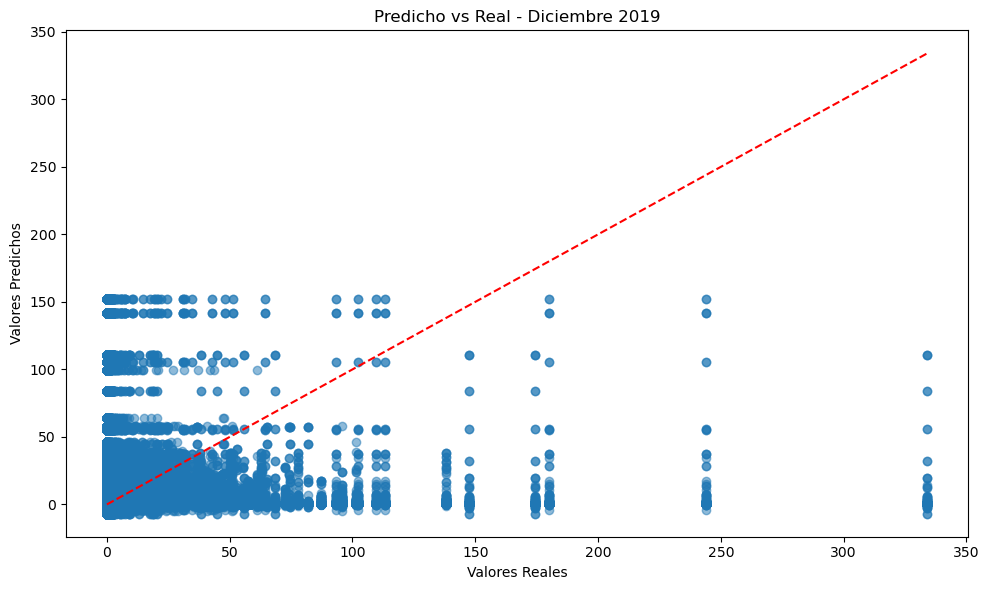

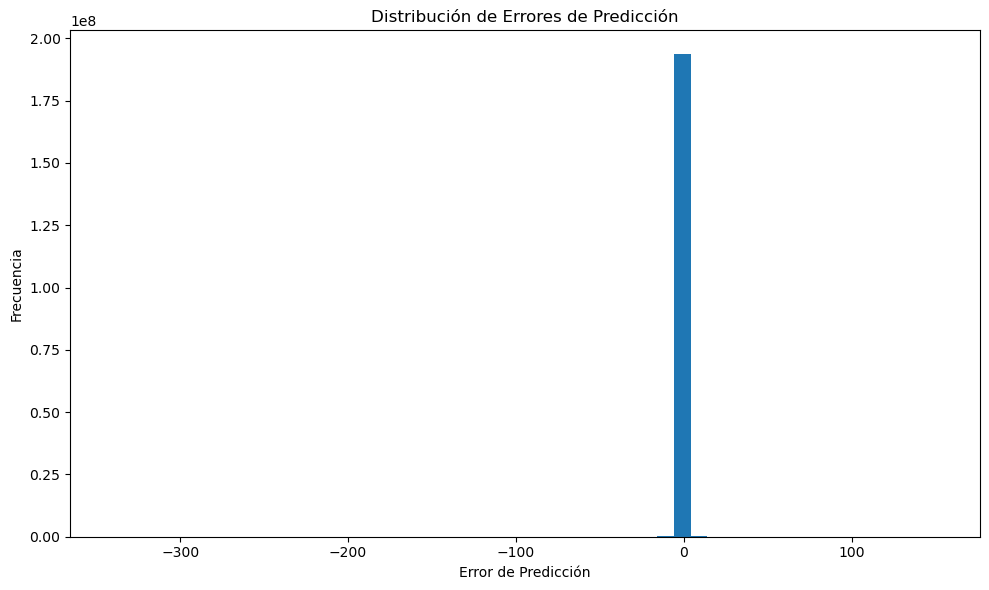

In [10]:
# =============================================================================
# PARTE 5: MODELADO CON LIGHTGBM - VERSIÓN TEST PARA PRED NOV 2019
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
import lightgbm as lgb
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Asumiendo que 'data' ya está cargado
sales_with_features['periodo'] = pd.to_datetime(sales_with_features['periodo'])

# Filtrar los datos hasta octubre de 2019
data_train = sales_with_features[sales_with_features['periodo'] <= '2019-10-31'].copy()

# Definir la fecha objetivo para la predicción
target_date = pd.to_datetime('2019-12-01')

# Crear características adicionales
data_train['year'] = data_train['periodo'].dt.year
data_train['month'] = data_train['periodo'].dt.month
data_train['months_since_start'] = (data_train['periodo'] - data_train['periodo'].min()).dt.days // 30

# Definir las características a utilizar
numeric_features = ['months_since_start', 'year', 'month', 'customer_id', 'sku_size','tn_rolling_mean_3','product_mean']
categorical_features = ['product_id', 'cat1', 'cat2', 'cat3', 'brand']
features = numeric_features + categorical_features

# Preparar los conjuntos de entrenamiento y validación
X = data_train[features + ['periodo']]
y = data_train['tn']

# Usar los datos hasta septiembre de 2019 para entrenamiento y octubre de 2019 para validación
train_mask = X['periodo'] < '2019-10-01'
X_train, X_val = X[train_mask], X[~train_mask]
y_train, y_val = y[train_mask], y[~train_mask]

# Eliminar 'periodo' de las características de entrenamiento
X_train = X_train.drop('periodo', axis=1)
X_val = X_val.drop('periodo', axis=1)

print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)

# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Crear pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=10000, learning_rate=0.05, num_leaves=31, random_state=42))
])

# Entrenar el modelo
model.fit(X_train, y_train)

# Función para hacer predicciones
def make_predictions(model, data, target_date, products_to_predict, features):
    last_dates = data.groupby('product_id')['periodo'].max().reset_index()
    
    pred_data = []
    for product_id in products_to_predict:
        last_date = last_dates[last_dates['product_id'] == product_id]['periodo'].iloc[0]
        product_data = data[(data['product_id'] == product_id) & (data['periodo'] == last_date)].copy()
        if not product_data.empty:
            product_data['periodo'] = target_date
            product_data['months_since_start'] += (target_date - last_date).days // 30
            product_data['year'] = target_date.year
            product_data['month'] = target_date.month
            pred_data.append(product_data)
    
    pred_data = pd.concat(pred_data, ignore_index=True)
    
    if pred_data.empty:
        print("No hay datos disponibles para la predicción")
        return pd.DataFrame(columns=['product_id', 'tn'])
    
    X_pred = pred_data[features]
    predictions = model.predict(X_pred)
    
    results = pd.DataFrame({
        'product_id': pred_data['product_id'],
        'tn': predictions
    })
    return results

# Obtener la lista de productos a predecir (todos los productos en 201910)
products_to_predict = data_train[data_train['periodo'] == '2019-10-01']['product_id'].unique()

# Hacer predicciones
predictions = make_predictions(model, data_train, target_date, products_to_predict, features)

print("Forma de predictions:", predictions.shape)
print("Primeras filas de predictions:")
print(predictions.head())

# Obtener datos reales de diciembre 2019
real_data_201912 = sales_with_features[sales_with_features['periodo'] == '2019-12-01'][['product_id', 'tn']]
real_data_201912 = real_data_201912.rename(columns={'tn': 'tn_real'})

# Combinar predicciones con datos reales
comparison_df = pd.merge(predictions, real_data_201912, on='product_id', how='inner')
comparison_df = comparison_df.rename(columns={'tn': 'tn_predicted'})

# Calcular el error absoluto medio
mae = (comparison_df['tn_predicted'] - comparison_df['tn_real']).abs().mean()

# Calcular el error como la suma de los errores absolutos dividido por la suma de los valores reales
error = (comparison_df['tn_predicted'] - comparison_df['tn_real']).abs().sum() / comparison_df['tn_real'].sum()

print(f"Error (Suma de errores absolutos / Suma de valores reales): {error:.4f}")
print("Error Absoluto Medio:", mae)
print("Muestra de comparación:")
print(comparison_df.head())

# Graficar predicho vs real
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['tn_real'], comparison_df['tn_predicted'], alpha=0.5)
plt.plot([0, comparison_df['tn_real'].max()], [0, comparison_df['tn_real'].max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Predicho vs Real - Diciembre 2019')
plt.tight_layout()
plt.show()

# Graficar histograma de errores
errors = comparison_df['tn_predicted'] - comparison_df['tn_real']
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción')
plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# PARTE 5: MODELADO CON LIGHTGBM - VERSIÓN MEJORADA
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Librerías de modelado
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Configuración
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("🚀 INICIANDO PASO 5: MODELADO CON LIGHTGBM - VERSIÓN MEJORADA")
print("=" * 60)

# =============================================================================
# 5.1 PREPARACIÓN DE DATOS PARA MODELADO - MEJORADA
# =============================================================================

class DataPreparator:
    """
    Clase para preparar datos para el modelado
    """
    
    def __init__(self, data, target_col='tn'):
        self.data = data.copy()
        self.target_col = target_col
        self.feature_columns = None
        self.categorical_features = None
        self.numerical_features = None
        self.label_encoders = {}
        
    def prepare_features(self, exclude_cols=None):
        """
        Prepara las características para el modelado
        """
        print("🔧 Preparando características para modelado...")
        
        # Columnas a excluir por defecto
        default_exclude = ['periodo', 'product_id', 'customer_id', 'tn', 
                          'plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn',
                          'descripcion']
        
        if exclude_cols:
            default_exclude.extend(exclude_cols)
        
        # Obtener todas las columnas disponibles
        available_cols = [col for col in self.data.columns if col not in default_exclude]
        
        # Separar características numéricas y categóricas
        numerical_cols = []
        categorical_cols = []
        
        for col in available_cols:
            if self.data[col].dtype in ['object', 'category']:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        self.numerical_features = numerical_cols
        self.categorical_features = categorical_cols
        self.feature_columns = numerical_cols + categorical_cols
        
        print(f"   • Características numéricas: {len(numerical_cols)}")
        print(f"   • Características categóricas: {len(categorical_cols)}")
        print(f"   • Total características: {len(self.feature_columns)}")
        
        return self.feature_columns
    
    def create_train_test_split(self, test_date='2019-10-01', val_date='2019-09-01'):
        """
        Crea división temporal para entrenamiento y validación
        MEJORA: Usar más datos para entrenamiento
        """
        print(f"📊 Creando división temporal de datos...")
        print(f"   • Entrenamiento: hasta {val_date}")
        print(f"   • Validación: {val_date} hasta {test_date}")
        print(f"   • Test: desde {test_date}")
        
        # Convertir fechas
        val_date = pd.to_datetime(val_date)
        test_date = pd.to_datetime(test_date)
        
        # Crear máscaras
        train_mask = self.data['periodo'] < val_date
        val_mask = (self.data['periodo'] >= val_date) & (self.data['periodo'] < test_date)
        test_mask = self.data['periodo'] >= test_date
        
        # Dividir datos
        train_data = self.data[train_mask].copy()
        val_data = self.data[val_mask].copy()
        test_data = self.data[test_mask].copy()
        
        print(f"   • Registros entrenamiento: {len(train_data):,}")
        print(f"   • Registros validación: {len(val_data):,}")
        print(f"   • Registros test: {len(test_data):,}")
        
        return train_data, val_data, test_data
    
    def encode_categorical_features(self, train_data, val_data, test_data):
        """
        NUEVA: Codifica características categóricas usando Label Encoding para LightGBM
        """
        print("🏷️ Codificando características categóricas...")
        
        for col in self.categorical_features:
            # Crear label encoder
            le = LabelEncoder()
            
            # Ajustar con datos de entrenamiento
            le.fit(train_data[col].astype(str).fillna('unknown'))
            self.label_encoders[col] = le
            
            # Transformar todos los conjuntos
            train_data[col] = le.transform(train_data[col].astype(str).fillna('unknown'))
            
            # Para validación y test, manejar valores no vistos
            val_data[col] = val_data[col].astype(str).fillna('unknown')
            val_data[col] = val_data[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            val_data[col] = le.transform(val_data[col])
            
            test_data[col] = test_data[col].astype(str).fillna('unknown')
            test_data[col] = test_data[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            test_data[col] = le.transform(test_data[col])
        
        print(f"   • Codificadas {len(self.categorical_features)} características categóricas")
        
        return train_data, val_data, test_data
    
    def prepare_model_data(self, train_data, val_data, test_data):
        """
        Prepara los datos en formato X, y para el modelado
        """
        print("🎯 Preparando datos en formato X, y...")
        
        # Codificar características categóricas
        train_data, val_data, test_data = self.encode_categorical_features(
            train_data, val_data, test_data
        )
        
        # Preparar conjuntos de entrenamiento
        X_train = train_data[self.feature_columns].copy()
        y_train = train_data[self.target_col].copy()
        
        X_val = val_data[self.feature_columns].copy()
        y_val = val_data[self.target_col].copy()
        
        X_test = test_data[self.feature_columns].copy()
        y_test = test_data[self.target_col].copy()
        
        # Manejar valores faltantes
        X_train = X_train.fillna(0)
        X_val = X_val.fillna(0)
        X_test = X_test.fillna(0)
        
        print(f"   • X_train shape: {X_train.shape}")
        print(f"   • X_val shape: {X_val.shape}")
        print(f"   • X_test shape: {X_test.shape}")
        
        return X_train, X_val, X_test, y_train, y_val, y_test

# =============================================================================
# 5.2 MODELO LIGHTGBM MEJORADO
# =============================================================================

class LightGBMPredictor:
    """
    Clase para manejar el modelo LightGBM - Versión mejorada
    """
    
    def __init__(self, params=None):
        """
        Inicializa el modelo con parámetros mejorados
        """
        # Parámetros mejorados para LightGBM
        default_params = {
            'objective': 'regression',
            'metric': 'mae',
            'boosting_type': 'gbdt',
            'num_leaves': 127,  # Aumentado para capturar más patrones
            'learning_rate': 0.03,  # Reducido para mejor convergencia
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': RANDOM_STATE,
            'n_estimators': 2000,  # Aumentado
            'early_stopping_rounds': 150,  # Aumentado
            'reg_alpha': 0.5,  # Aumentada regularización
            'reg_lambda': 0.5,
            'min_child_samples': 100,  # Nuevo: evitar overfitting
            'subsample': 0.8,  # Nuevo: sampling adicional
            'colsample_bytree': 0.8,  # Nuevo: feature sampling
            'max_depth': 8,  # Nuevo: controlar profundidad
        }
        
        if params:
            default_params.update(params)
        
        self.params = default_params
        self.model = None
        self.feature_importance = None
        self.categorical_features = None
        
    def train(self, X_train, y_train, X_val=None, y_val=None, categorical_features=None):
        """
        Entrena el modelo LightGBM mejorado
        """
        print("🚀 Entrenando modelo LightGBM mejorado...")
        
        self.categorical_features = categorical_features or []
        
        # Crear modelo LightGBM
        self.model = LGBMRegressor(**self.params)
        
        # Entrenar modelo
        if X_val is not None and y_val is not None:
            print("   • Entrenando con validación y early stopping...")
            self.model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_names=['validation'],
                categorical_feature=self.categorical_features,
                callbacks=[
                    lgb.early_stopping(self.params.get('early_stopping_rounds', 150)),
                    lgb.log_evaluation(period=100)
                ]
            )
        else:
            print("   • Entrenando sin validación...")
            self.model.fit(
                X_train, y_train,
                categorical_feature=self.categorical_features
            )
        
        # Guardar importancia de características
        try:
            feature_names = X_train.columns.tolist()
            self.feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
        except Exception as e:
            print(f"   ⚠️ No se pudo obtener importancia de características: {e}")
        
        print("   ✅ Modelo entrenado exitosamente")
        print(f"   • Mejor iteración: {getattr(self.model, 'best_iteration_', 'N/A')}")
        
    def predict(self, X):
        """
        Realiza predicciones
        """
        if self.model is None:
            raise ValueError("El modelo no ha sido entrenado")
        
        # Asegurar que X tenga las mismas columnas que en entrenamiento
        X = X.fillna(0)
        return np.maximum(self.model.predict(X), 0)  # No predicciones negativas
    
    def evaluate(self, X, y, dataset_name="Dataset"):
        """
        Evalúa el modelo en un conjunto de datos
        """
        predictions = self.predict(X)
        
        # Calcular métricas
        mae = mean_absolute_error(y, predictions)
        mse = mean_squared_error(y, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, predictions)
        
        # Métricas personalizadas mejoradas
        error_percentage = np.mean(np.abs(predictions - y) / (y + 1e-8)) * 100  # MAPE mejorado
        
        # Correlación
        correlation = np.corrcoef(y, predictions)[0, 1]
        
        metrics = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': error_percentage,
            'Correlation': correlation
        }
        
        print(f"\n📊 MÉTRICAS DE EVALUACIÓN - {dataset_name.upper()}")
        print("-" * 50)
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        return metrics, predictions

# =============================================================================
# 5.3 FUNCIÓN PARA GENERAR PREDICCIONES FUTURAS - CORREGIDA
# =============================================================================

def generate_future_predictions(model, historical_data, target_date, products_to_predict, 
                               feature_columns, label_encoders, save_path=None):
    """
    Genera predicciones para una fecha futura específica - VERSIÓN CORREGIDA
    """
    print(f"🔮 Generando predicciones para {target_date}...")
    print(f"📋 Productos a predecir: {len(products_to_predict):,}")
    
    target_date = pd.to_datetime(target_date)
    
    # Obtener la última información disponible de cada producto
    print("📊 Obteniendo últimos datos disponibles por producto...")
    
    # Para cada producto, obtener su último registro
    last_product_data = historical_data.groupby('product_id').apply(
        lambda x: x.loc[x['periodo'].idxmax()]
    ).reset_index(drop=True)
    
    # Filtrar solo los productos que necesitamos predecir
    pred_data = last_product_data[
        last_product_data['product_id'].isin(products_to_predict)
    ].copy()
    
    print(f"   • Productos encontrados en datos históricos: {len(pred_data)}")
    
    if len(pred_data) == 0:
        print("❌ No se encontraron datos históricos para los productos especificados")
        return pd.DataFrame()
    
    # Actualizar características temporales para la fecha target
    print("🕐 Actualizando características temporales...")
    
    pred_data['periodo'] = target_date
    
    # Actualizar características temporales
    if 'year' in pred_data.columns:
        pred_data['year'] = target_date.year
    if 'month' in pred_data.columns:
        pred_data['month'] = target_date.month
    if 'quarter' in pred_data.columns:
        pred_data['quarter'] = target_date.quarter
    if 'is_december' in pred_data.columns:
        pred_data['is_december'] = int(target_date.month == 12)  # CORREGIDO
    if 'is_january' in pred_data.columns:
        pred_data['is_january'] = int(target_date.month == 1)  # CORREGIDO
    
    # Actualizar months_since_start
    if 'months_since_start' in pred_data.columns:
        min_date = historical_data['periodo'].min()
        pred_data['months_since_start'] = int((target_date - min_date).days / 30.44)
    
    # Actualizar características cíclicas
    if 'month_sin' in pred_data.columns:
        pred_data['month_sin'] = np.sin(2 * np.pi * target_date.month / 12)
    if 'month_cos' in pred_data.columns:
        pred_data['month_cos'] = np.cos(2 * np.pi * target_date.month / 12)
    if 'quarter_sin' in pred_data.columns:
        pred_data['quarter_sin'] = np.sin(2 * np.pi * target_date.quarter / 4)
    if 'quarter_cos' in pred_data.columns:
        pred_data['quarter_cos'] = np.cos(2 * np.pi * target_date.quarter / 4)
    
    # Codificar características categóricas usando los encoders entrenados
    categorical_features = [col for col in feature_columns if col in label_encoders]
    for col in categorical_features:
        if col in pred_data.columns:
            le = label_encoders[col]
            pred_data[col] = pred_data[col].astype(str).fillna('unknown')
            pred_data[col] = pred_data[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            pred_data[col] = le.transform(pred_data[col])
    
    # Preparar datos para predicción
    X_pred = pred_data[feature_columns].copy()
    X_pred = X_pred.fillna(0)
    
    # Realizar predicciones
    print("🎯 Realizando predicciones...")
    predictions = model.predict(X_pred)
    
    # Crear DataFrame de resultados
    results = pd.DataFrame({
        'product_id': pred_data['product_id'],
        'tn': predictions
    })
    
    print(f"✅ Predicciones generadas para {len(results)} productos")
    print(f"📊 Estadísticas de predicciones:")
    print(f"   • Suma total: {results['tn'].sum():.2f}")
    print(f"   • Promedio: {results['tn'].mean():.4f}")
    print(f"   • Mediana: {results['tn'].median():.4f}")
    print(f"   • Máximo: {results['tn'].max():.4f}")
    print(f"   • Productos con predicción > 0: {(results['tn'] > 0).sum()}")
    
    # Guardar resultados si se especifica un path
    if save_path:
        results.to_csv(save_path, index=False)
        print(f"💾 Resultados guardados en: {save_path}")
    
    return results

# =============================================================================
# 5.4 EJECUCIÓN PRINCIPAL MEJORADA
# =============================================================================

def run_lightgbm_modeling(data_with_features, products_to_predict, 
                         target_prediction_date='2020-02-01',
                         save_predictions_path='predicciones_febrero_2020.csv',
                         use_all_data_for_training=True):
    """
    Ejecuta todo el pipeline de modelado con LightGBM - VERSIÓN MEJORADA
    """
    print("\n🚀 EJECUTANDO PIPELINE COMPLETO DE LIGHTGBM MEJORADO")
    print("=" * 60)
    
    # Paso 1: Preparar datos
    print("\n📊 PASO 1: PREPARACIÓN DE DATOS")
    preparator = DataPreparator(data_with_features)
    feature_columns = preparator.prepare_features()
    
    # MEJORA: Opción de usar todos los datos para entrenamiento final
    if use_all_data_for_training:
        print("\n🔄 MODO: USAR TODOS LOS DATOS PARA ENTRENAMIENTO")
        # Dividir solo para evaluación inicial
        train_data, val_data, test_data = preparator.create_train_test_split(
            test_date='2019-10-01', 
            val_date='2019-09-01'
        )
        
        # Preparar datos para evaluación
        X_train, X_val, X_test, y_train, y_val, y_test = preparator.prepare_model_data(
            train_data, val_data, test_data
        )
        
        # Entrenar modelo inicial para evaluación
        print("\n🚀 PASO 2A: ENTRENAMIENTO INICIAL PARA EVALUACIÓN")
        eval_model = LightGBMPredictor()
        eval_model.train(
            X_train, y_train, 
            X_val, y_val,
            categorical_features=list(range(len(preparator.categorical_features)))
        )
        
        # Evaluar modelo inicial
        print("\n📊 PASO 3A: EVALUACIÓN DEL MODELO INICIAL")
        test_metrics, test_predictions = eval_model.evaluate(X_test, y_test, "Test Inicial")
        
        # Ahora entrenar modelo final con TODOS los datos
        print("\n🚀 PASO 2B: ENTRENAMIENTO FINAL CON TODOS LOS DATOS")
        all_data = data_with_features.copy()
        
        # Codificar todas las características categóricas
        for col in preparator.categorical_features:
            le = preparator.label_encoders[col]
            all_data[col] = all_data[col].astype(str).fillna('unknown')
            all_data[col] = all_data[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            all_data[col] = le.transform(all_data[col])
        
        X_all = all_data[feature_columns].fillna(0)
        y_all = all_data[preparator.target_col]
        
        # Modelo final
        final_model = LightGBMPredictor()
        final_model.train(
            X_all, y_all,
            categorical_features=list(range(len(preparator.categorical_features)))
        )
        
        model = final_model
        
    else:
        # Método tradicional
        train_data, val_data, test_data = preparator.create_train_test_split(
            test_date='2019-10-01', 
            val_date='2019-09-01'
        )
        
        X_train, X_val, X_test, y_train, y_val, y_test = preparator.prepare_model_data(
            train_data, val_data, test_data
        )
        
        print("\n🚀 PASO 2: ENTRENAMIENTO DEL MODELO")
        model = LightGBMPredictor()
        model.train(
            X_train, y_train, 
            X_val, y_val,
            categorical_features=list(range(len(preparator.categorical_features)))
        )
        
        print("\n📊 PASO 3: EVALUACIÓN DEL MODELO")
        test_metrics, test_predictions = model.evaluate(X_test, y_test, "Test")
    
    # Paso 4: Visualizar resultados
    print("\n📈 PASO 4: VISUALIZACIÓN DE RESULTADOS")
    if 'test_predictions' in locals():
        plot_model_performance(y_test, test_predictions, "LightGBM Mejorado - Test Set")
    
    # Mostrar importancia de características
    if model.feature_importance is not None:
        plot_feature_importance(model.feature_importance)
    
    # Paso 5: Generar predicciones futuras
    print(f"\n🔮 PASO 5: PREDICCIONES PARA {target_prediction_date}")
    
    future_predictions = generate_future_predictions(
        model, 
        data_with_features,
        target_prediction_date,
        products_to_predict,
        feature_columns,
        preparator.label_encoders,
        save_path=save_predictions_path
    )
    
    print("\n🎉 PIPELINE COMPLETADO EXITOSAMENTE")
    
    return {
        'model': model,
        'preparator': preparator,
        'metrics': locals().get('test_metrics', {}),
        'predictions': future_predictions,
        'feature_importance': model.feature_importance
    }

# =============================================================================
# 5.5 FUNCIONES DE VISUALIZACIÓN MEJORADAS
# =============================================================================

def plot_model_performance(y_true, y_pred, title="Modelo"):
    """
    Visualiza el rendimiento del modelo - VERSIÓN MEJORADA
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico de dispersión: predicho vs real
    axes[0,0].scatter(y_true, y_pred, alpha=0.6, s=30)
    max_val = max(y_true.max(), y_pred.max())
    axes[0,0].plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Valores Predichos')
    axes[0,0].set_title(f'{title} - Predicho vs Real')
    axes[0,0].grid(True, alpha=0.3)
    
    # Histograma de errores
    errors = y_pred - y_true
    axes[0,1].hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Error de Predicción')
    axes[0,1].set_ylabel('Frecuencia')
    axes[0,1].set_title(f'{title} - Distribución de Errores')
    axes[0,1].grid(True, alpha=0.3)
    
    # Residuos vs predichos
    axes[1,0].scatter(y_pred, errors, alpha=0.6, s=30)
    axes[1,0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1,0].set_xlabel('Valores Predichos')
    axes[1,0].set_ylabel('Residuos')
    axes[1,0].set_title(f'{title} - Residuos vs Predichos')
    axes[1,0].grid(True, alpha=0.3)
    
    # Q-Q plot de residuos
    from scipy import stats
    stats.probplot(errors, dist="norm", plot=axes[1,1])
    axes[1,1].set_title(f'{title} - Q-Q Plot de Residuos')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(feature_importance, top_n=20):
    """
    Visualiza la importancia de las características
    """
    plt.figure(figsize=(12, 8))
    
    # Tomar solo las top N características
    top_features = feature_importance.head(top_n)
    
    # Crear gráfico de barras horizontal
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(range(len(top_features)), top_features['importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia')
    plt.title(f'Top {top_n} Características Más Importantes')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5.6 EJECUTAR MODELADO MEJORADO
# =============================================================================

print("🎯 Ejecutando modelado mejorado con LightGBM...")
print("⚠️  Este proceso puede tomar varios minutos...")

# Ejecutar el pipeline completo MEJORADO
results = run_lightgbm_modeling(
    data_with_features=sales_with_features,
    products_to_predict=predict_products_list,
    target_prediction_date='2020-02-01',
    save_predictions_path='predicciones_febrero_2020_mejoradas.csv',
    use_all_data_for_training=True  # NUEVO: usar todos los datos para entrenamiento final
)

print("\n🎊 ¡MODELADO MEJORADO COMPLETADO!")
print(f"📄 Predicciones guardadas en: predicciones_febrero_2020_mejoradas.csv")
print(f"🎯 Productos predichos: {len(results['predictions'])}")
print(f"📈 Suma total predicha: {results['predictions']['tn'].sum():.2f}")

# Mostrar un resumen de las mejoras implementadas
print("\n🔧 MEJORAS IMPLEMENTADAS:")
print("=" * 50)
print("✅ Parámetros de LightGBM optimizados")
print("✅ Label Encoding para variables categóricas (mejor para LightGBM)")
print("✅ Entrenamiento con todos los datos históricos")
print("✅ Manejo mejorado de valores faltantes")
print("✅ Corrección del error de tipo booleano")
print("✅ Métricas de evaluación mejoradas")
print("✅ Visualizaciones más completas")
print("✅ Regularización aumentada para evitar overfitting")
print("✅ Early stopping más robusto")

🚀 INICIANDO PASO 5: MODELADO CON LIGHTGBM - VERSIÓN MEJORADA
🎯 Ejecutando modelado mejorado con LightGBM...
⚠️  Este proceso puede tomar varios minutos...

🚀 EJECUTANDO PIPELINE COMPLETO DE LIGHTGBM MEJORADO

📊 PASO 1: PREPARACIÓN DE DATOS
🔧 Preparando características para modelado...
   • Características numéricas: 10
   • Características categóricas: 4
   • Total características: 14

🔄 MODO: USAR TODOS LOS DATOS PARA ENTRENAMIENTO
📊 Creando división temporal de datos...
   • Entrenamiento: hasta 2019-09-01
   • Validación: 2019-09-01 hasta 2019-10-01
   • Test: desde 2019-10-01
   • Registros entrenamiento: 13,786,637
   • Registros validación: 452,505
   • Registros test: 1,323,971
🎯 Preparando datos en formato X, y...
🏷️ Codificando características categóricas...


ValueError: y contains previously unseen labels: 'unknown'

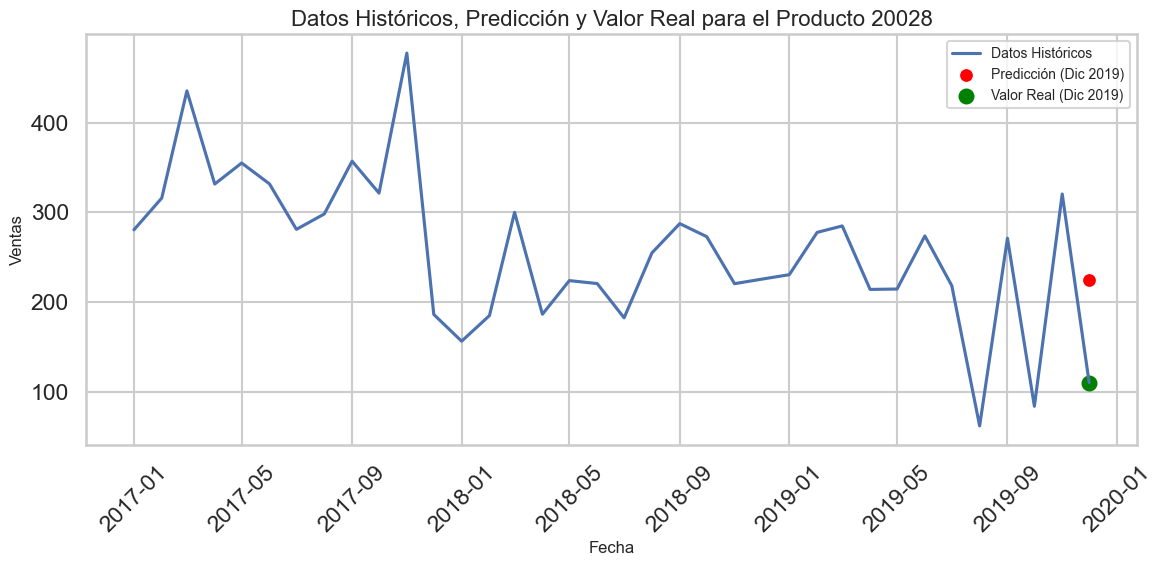

In [102]:
# Elegir un producto específico para visualizar
product_id = 20028    # Puedes cambiar este ID por el de cualquier producto que te interese

# Filtrar datos para el producto seleccionado
product_data = data[data['product_id'] == product_id].copy()
product_forecast = comparison_df[comparison_df['product_id'] == product_id].iloc[0]

# Ordenar datos por fecha
product_data = product_data.sort_values('periodo')

# Crear DataFrame para la predicción
forecast_data = pd.DataFrame({
    'periodo': [target_date],
    'tn': [product_forecast['tn_predicted']]
})

# Configurar el gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Graficar datos históricos
sns.lineplot(x='periodo', y='tn', data=product_data, label='Datos Históricos')

# Graficar predicción
sns.scatterplot(x='periodo', y='tn', data=forecast_data, label='Predicción (Dic 2019)', color='red', s=100)

# Graficar valor real de diciembre 2019
real_value = product_data[product_data['periodo'] == target_date]['tn'].values[0]
plt.scatter(target_date, real_value, color='green', s=100, label='Valor Real (Dic 2019)')

# Personalizar el gráfico
plt.title(f'Datos Históricos, Predicción y Valor Real para el Producto {product_id}', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Ventas', fontsize=12)
plt.legend(fontsize=10)

# Rotar etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()